Gamma Oscillation Analysis

Reference

Kirli, K. K., Ermentrout, G. B., & Cho, R. Y. (2014). Computational study of NMDA conductance and cortical oscillations in schizophrenia. Frontiers in Computational Neuroscience, 8:133. https://doi.org/10.3389/fncom.2014.00133

In [ ]:
import os
from pathlib import Path
import sys


import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from scipy.signal import spectrogram


PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


from src.utilities import run_one_point



in this section, we examine whether the simulated E–I network generates gamma-band oscillations (20–80 Hz) and how these oscillations depend on model parameters.

The local field potential (LFP) is defined as the population mean membrane voltage of excitatory (E) neurons, providing a proxy for aggregate cortical activity. To detect rhythmic structure, the LFP is analyzed in the frequency domain using the Fast Fourier Transform (FFT). The 10 s signal is divided into 1-second segments, detrended, windowed, and transformed to obtain power spectra.

Within the gamma band, the dominant oscillation frequency is defined as the frequency with maximal locally averaged power. Oscillation strength is quantified as the mean power within a ±3 Hz window around this peak. Results are then averaged across time segments to obtain stable estimates.

This analysis is repeated while varying NMDA conductance onto inhibitory neurons (gNI) and the external current applied to inhibitory neurons (Iapp_I). Line plots and heatmaps illustrate how peak frequency and gamma power change across parameter space, while time-domain traces and spectrograms verify temporal stability.

Overall, this section identifies the parameter regimes that produce strong, coherent gamma oscillations and characterizes how inhibitory drive shapes their frequency and power.




In [ ]:

# Prevent oversubscription (many processes × many BLAS threads)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"




# ----------------------------
# Parameters 
# ----------------------------
g_values     = np.linspace(0.0, 0.06, 7)   # NMDA conductance
IappI_values = np.linspace(0.0, 0.8, 9)    # inhibitory current

dt_ms = 0.05
T_ms = 10000.0
rng_seed = 0
alpha_n_per_ms = 0.5

#  (gg, IappI) combinations
tasks = [(g, IappI) for IappI in IappI_values for g in g_values]

# Run in parallel: n_jobs=-1 uses all logical cores
results = Parallel(n_jobs=-1, backend="loky", verbose=10)(
    delayed(run_one_point)(g, IappI, dt_ms, T_ms, rng_seed, alpha_n_per_ms)
    for g, IappI in tasks
)

# ----------------------------
# Pack results into heatmaps
# ----------------------------
freq_map  = np.full((len(IappI_values), len(g_values)), np.nan, dtype=float)
power_map = np.full((len(IappI_values), len(g_values)), np.nan, dtype=float)

g_index = {float(g): j for j, g in enumerate(g_values)}
I_index = {float(I): i for i, I in enumerate(IappI_values)}

lfp_map = {}

for g, IappI, f0, P0, lfp in results:
    i = I_index[IappI]
    j = g_index[g]

    freq_map[i, j] = f0
    power_map[i, j] = P0
    lfp_map[(i, j)] = lfp




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  39 out of  63 | elapsed:  4.0min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  46 out of  63 | elapsed:  4.3min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  53 out of  63 | elapsed:  5.2min remaining:   58.8s
[Parallel(n_jobs=-1)]: Done  60 out of  63 | elapsed:  5.4min remaining:   16.1s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:  5.5min finished


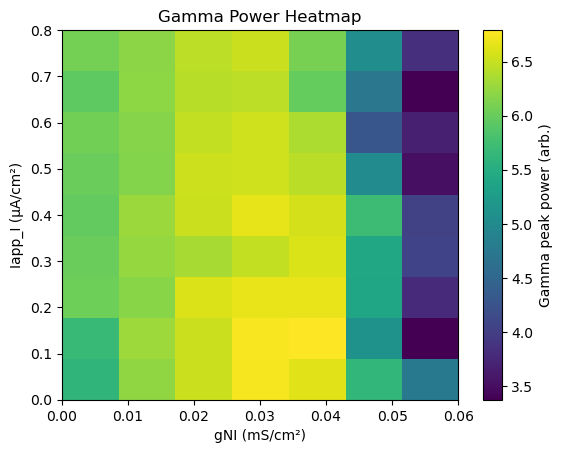

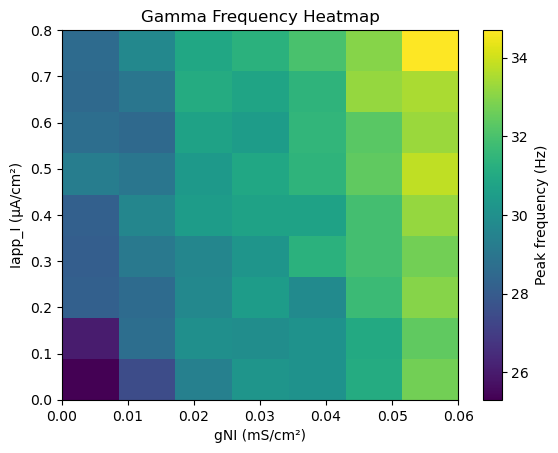

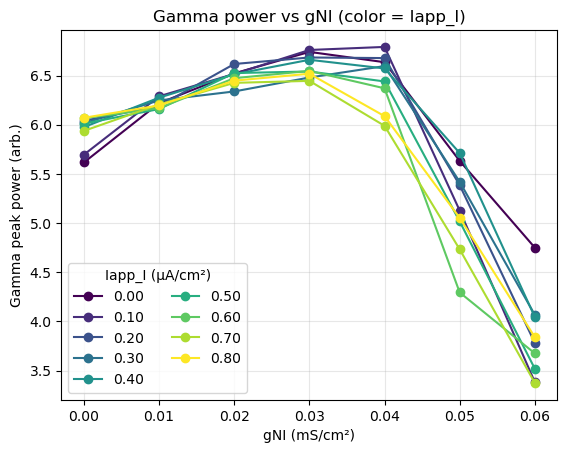

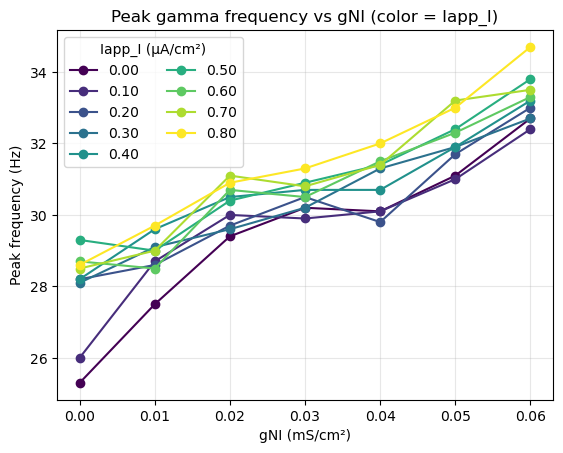

In [3]:
# ----------------------------
# Plot heatmaps
# ----------------------------
plt.figure()
plt.imshow(
    power_map,
    aspect="auto",
    origin="lower",
    extent=[g_values[0], g_values[-1], IappI_values[0], IappI_values[-1]]
)
plt.colorbar(label="Gamma peak power (arb.)")
plt.xlabel("gNI (mS/cm²)")
plt.ylabel("Iapp_I (µA/cm²)")
plt.title("Gamma Power Heatmap")
plt.show()

plt.figure()
plt.imshow(
    freq_map,
    aspect="auto",
    origin="lower",
    extent=[g_values[0], g_values[-1], IappI_values[0], IappI_values[-1]]
)
plt.colorbar(label="Peak frequency (Hz)")
plt.xlabel("gNI (mS/cm²)")
plt.ylabel("Iapp_I (µA/cm²)")
plt.title("Gamma Frequency Heatmap")
plt.show()



cmap = plt.cm.viridis
g_values_plot = np.linspace(0.0, 0.06, power_map.shape[1])

plt.figure()
for i, IappI in enumerate(IappI_values):
    plt.plot(
        g_values_plot,
        power_map[i, :],
        marker="o",
        color=cmap(i / (len(IappI_values) - 1)),
        label=f"{IappI:.2f}"
    )

plt.legend(title="Iapp_I (µA/cm²)", ncol=2)
plt.xlabel("gNI (mS/cm²)")
plt.ylabel("Gamma peak power (arb.)")
plt.title("Gamma power vs gNI (color = Iapp_I)")
plt.grid(True, alpha=0.3)
plt.show()


cmap = plt.cm.viridis   # or viridis / plasma / turbo / inferno

g_values_plot = np.linspace(0.0, 0.06, freq_map.shape[1])  # matches columns

plt.figure()
for i, IappI in enumerate(IappI_values):
    plt.plot(
        g_values_plot,
        freq_map[i, :],              # <-- frequency row
        marker="o",
        color=cmap(i / (len(IappI_values) - 1)),
        label=f"{IappI:.2f}"
    )

plt.legend(title="Iapp_I (µA/cm²)", ncol=2)
plt.xlabel("gNI (mS/cm²)")
plt.ylabel("Peak frequency (Hz)")
plt.title("Peak gamma frequency vs gNI (color = Iapp_I)")
plt.grid(True, alpha=0.3)
plt.show()


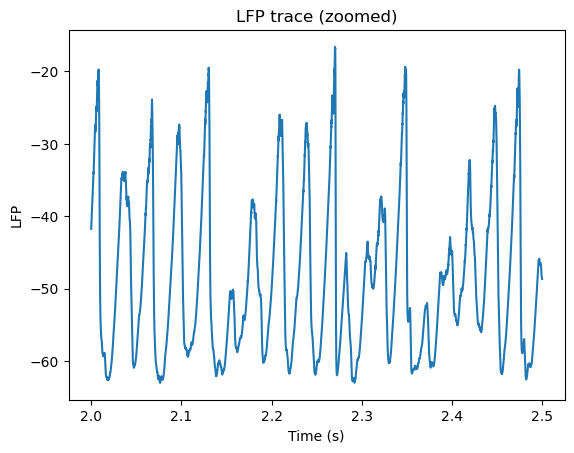

In [ ]:
dt=0.05
start_s = 2.0      # seconds (after transient)
duration_s = 0.5   # window length

start = int(start_s * 1000 / dt)
end   = int((start_s + duration_s) * 1000 / dt)

t = np.arange(start, end) * dt / 1000

plt.figure()
plt.plot(t, lfp[start:end])
plt.xlabel("Time (s)")
plt.ylabel("LFP")
plt.title("LFP trace (zoomed)")
plt.show()



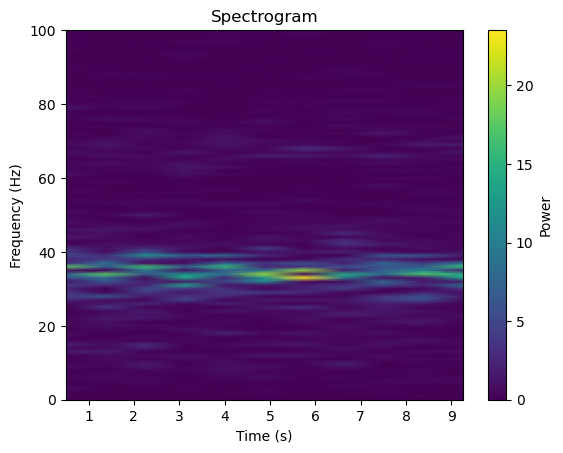

In [ ]:


fs = 1.0 / (dt * 1e-3)

f, t, S = spectrogram(lfp, fs=fs, nperseg=int(fs))

plt.pcolormesh(t, f, S, shading='gouraud')
plt.ylim(0, 100)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Spectrogram')
plt.colorbar(label="Power")
plt.show()


### Gamma Frequency

Peak gamma frequency increases monotonically with gNI across all levels of inhibitory drive (Iapp_I). Frequencies shift from ~26–29 Hz at low gNI to ~33–35 Hz at high gNI, remaining within the gamma band. This is consistent with stronger interneuron recruitment shortening the E–I cycle and increasing oscillation frequency.

### Gamma Power

Gamma power exhibits a clear inverted-U dependence on gNI:

- Low gNI → weak synchrony and low power

- Intermediate gNI → maximal gamma power

- High gNI → excessive inhibition and reduced power

This ∩-shaped relationship is robust across Iapp_I values and matches the core result of the paper: NMDA conductance onto interneurons modulates gamma synchrony nonlinearly.

### Overall

The model reproduces the key qualitative findings:

- Monotonic frequency modulation

- Inverted-U gamma power

- Stable narrowband oscillations in an intermediate regime

These results confirm that the implemented network captures the essential mechanism linking interneuron NMDA conductance and cortical gamma oscillations.

# next 

NMDA Receptors on Pyramidal Cells (gNE)

Section: NMDA receptors on the pyramidal cells
(See Figure 3) 


	​

 shoud lead to:

Monotonic increase in frequency

Generally monotonic increase in power

Unlike gNI, there is no inverted-U

NMDA on pyramidal cells primarily increases excitability rather than creating nonlinear suppression

Why this matters

This demonstrates cell-type specificity:

NMDA on interneurons → inverted-U gamma power

NMDA on pyramidal cells → more monotonic modulation